## Gather data from db and preapre work


In [1]:
import pandas as pd
import numpy as np
from pymongo import MongoClient
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt

# 1. Database connection
client = MongoClient("mongodb://mongodb:27017/")
db = client.stock_database
collection = db.prices

# Fetch all BTC records sorted by date ascending
data = list(collection.find({'asset': 'BTC-USD'}).sort('Date', 1))
df = pd.DataFrame(data)

print(f"--- Loaded {len(df)} historical records for BTC-USD ---")

--- Loaded 4136 historical records for BTC-USD ---


## Future Engineering

In [2]:
# 2. Feature Engineering for Long-term Data
df['Date'] = pd.to_datetime(df['Date'])

# Yesterday's price
df['Price_Yesterday'] = df['Close'].shift(1)

# Short-term trend (5 days) and Long-term trend (20 days)
df['MA5'] = df['Close'].rolling(window=5).mean()
df['MA20'] = df['Close'].rolling(window=20).mean()

# Market Volatility (High-Low range)
df['Volatility'] = df['High'] - df['Low']

# Clean data: rolling and shift create NaN values at the beginning
df.dropna(inplace=True)

print(f"--- Feature engineering complete. Dataset size after cleaning: {len(df)} ---")

--- Feature engineering complete. Dataset size after cleaning: 4117 ---


## Data Splitting

In [3]:
# 3. Data Splitting
features = ['Price_Yesterday', 'MA5', 'MA20', 'Volatility']
X = df[features]
y = df['Close']

# We take the last 60 days for testing, everything before for training
test_days = 60
X_train, X_test = X.iloc[:-test_days], X.iloc[-test_days:]
y_train, y_test = y.iloc[:-test_days], y.iloc[-test_days:]

print(f"Training on: {len(X_train)} days | Testing on: {len(X_test)} days")

Training on: 4057 days | Testing on: 60 days


## Pipeline and GridSearchCV config

In [4]:
# 4. Building the Model Pipeline
# Pipeline ensures scaling is applied correctly to training and test sets separately
model_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svr', SVR(kernel='rbf'))
])

# Param grid focused on high C for Bitcoin's volatility
param_grid = {
    'svr__C': [1000, 5000, 10000],
    'svr__gamma': [0.001, 0.01, 0.1]
}

# 5-fold Cross-Validation
grid_search = GridSearchCV(model_pipeline, param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
print(f"--- Optimization Complete. Best Parameters: {grid_search.best_params_} ---")

--- Optimization Complete. Best Parameters: {'svr__C': 10000, 'svr__gamma': 0.001} ---


## Predictions



--- PERFORMANCE METRICS ---
Mean Absolute Error: $1778.44
Average Accuracy (MAPE): 98.02%


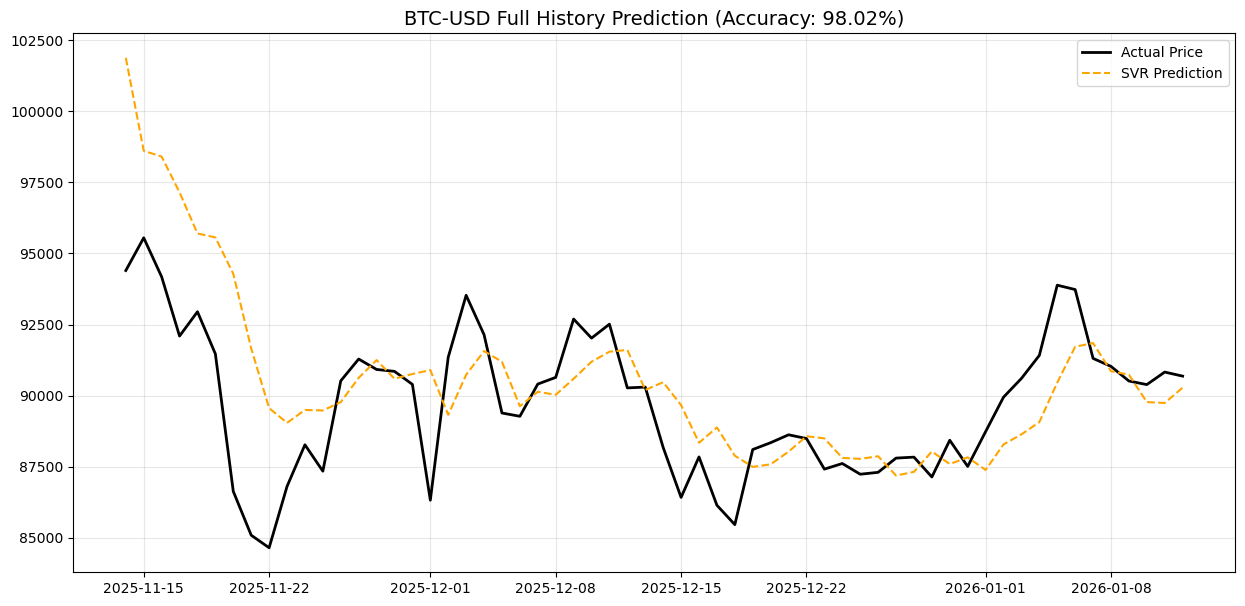

In [5]:
# 5. Prediction and Evaluation
predictions = best_model.predict(X_test)

mae = mean_absolute_error(y_test, predictions)
mape = mean_absolute_percentage_error(y_test, predictions) * 100

print(f"\n--- PERFORMANCE METRICS ---")
print(f"Mean Absolute Error: ${mae:.2f}")
print(f"Average Accuracy (MAPE): {100 - mape:.2f}%")

# 6. Final Visualization
plt.figure(figsize=(15, 7))
plt.plot(df['Date'].iloc[-test_days:], y_test, label="Actual Price", color='black', linewidth=2)
plt.plot(df['Date'].iloc[-test_days:], predictions, label="SVR Prediction", color='orange', linestyle='--')
plt.title(f"BTC-USD Full History Prediction (Accuracy: {100-mape:.2f}%)", fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [6]:
# 1. Get exact dates for Training and Testing sets
train_start = df['Date'].iloc[0].strftime('%Y-%m-%d')
train_end = df['Date'].iloc[-test_days - 1].strftime('%Y-%m-%d')

test_start = df['Date'].iloc[-test_days].strftime('%Y-%m-%d')
test_end = df['Date'].iloc[-1].strftime('%Y-%m-%d')

print(f"--- DATASET TEMPORAL RANGES ---")
print(f"Full dataset duration: {train_start} to {test_end}")
print(f"TRAINING PHASE: {train_start} to {train_end}")
print(f"TESTING PHASE (In-sample prediction): {test_start} to {test_end}")
print(f"Total training days: {len(X_train)}")
print(f"Total testing days: {len(X_test)}")

--- DATASET TEMPORAL RANGES ---
Full dataset duration: 2014-10-06 to 2026-01-12
TRAINING PHASE: 2014-10-06 to 2025-11-13
TESTING PHASE (In-sample prediction): 2025-11-14 to 2026-01-12
Total training days: 4057
Total testing days: 60


## Tomarrow prediction


In [8]:
# 1. Prepare features from the very last available record
last_row = df.iloc[-1]
current_features = np.array([[
    last_row['Close'],      # This becomes 'Price_Yesterday' for tomorrow
    df['Close'].iloc[-5:].mean(),  # New MA5 including today
    df['Close'].iloc[-20:].mean(), # New MA20 including today
    last_row['High'] - last_row['Low'] # Today's volatility
]])

# 2. Predict tomorrow's price
# We use best_model from GridSearchCV
tomorrow_prediction = best_model.predict(pd.DataFrame(current_features, columns=features))[0]

print(f"--- TOMORROW'S PREDICTION ---")
print(f"Latest Date in Data: {last_row['Date'].strftime('%Y-%m-%d')}")
print(f"Latest Closing Price: ${last_row['Close']:.2f}")
print(f"Model Prediction for Next Session: ${tomorrow_prediction:.2f}")
print(f"Predicted Change: ${tomorrow_prediction - last_row['Close']:.2f} ({((tomorrow_prediction/last_row['Close'])-1)*100:.2f}%)")

--- TOMORROW'S PREDICTION ---
Latest Date in Data: 2026-01-12
Latest Closing Price: $90684.45
Model Prediction for Next Session: $90228.63
Predicted Change: $-455.82 (-0.50%)


## Save tomarrows prediction to DB


In [9]:
from datetime import datetime

# 1. Access the predictions collection
pred_collection = db.predictions

# 2. Create the document to store
prediction_entry = {
    "execution_date": datetime.now().strftime('%Y-%m-%d'),
    "target_date": (datetime.now() + pd.Timedelta(days=1)).strftime('%Y-%m-%d'),
    "asset": "BTC-USD",
    "predicted_close": float(tomorrow_prediction),
    "actual_close": None, # This will be updated tomorrow
    "error_abs": None,
    "status": "pending"
}

# 3. Save to MongoDB
# We use update_one with upsert=True to avoid duplicates if you run it twice today
pred_collection.update_one(
    {"execution_date": prediction_entry["execution_date"], "asset": "BTC-USD"},
    {"$set": prediction_entry},
    upsert=True
)

print(f"--- PREDICTION SAVED ---")
print(f"Target date for verification: {prediction_entry['target_date']}")


--- PREDICTION SAVED ---
Target date for verification: 2026-01-13


## Verification Script


In [ ]:
def auto_verify_predictions():
    # 1. Find all pending predictions
    pending = list(pred_collection.find({"status": "pending"}))
    
    if not pending:
        print("No pending predictions to verify.")
        return

    for p in pending:
        target_date = p['target_date']
        print(f"Verifying prediction for {p['asset']} on {target_date}...")
        
        # 2. Download actual data for that specific day
        ticker = yf.Ticker(p['asset'])
        # We download 2 days to be sure we get the close price for the target date
        hist = ticker.history(start=target_date)
        
        if hist.empty or hist.index[0].strftime('%Y-%m-%d') != target_date:
            print(f"Data for {target_date} is not yet available in Yahoo Finance.")
            continue
            
        actual_price = float(hist['Close'].iloc[0])
        predicted_price = p['predicted_close']
        
        # 3. Calculate metrics
        error_abs = abs(actual_price - predicted_price)
        
        # 4. Update MongoDB
        pred_collection.update_one(
            {"_id": p["_id"]},
            {"$set": {
                "actual_close": actual_price,
                "error_abs": error_abs,
                "status": "verified"
            }}
        )
        print(f"✅ Verified! Error: ${error_abs:.2f}")

# Run tomorrow to update your database
# auto_verify_predictions()